# Project. 통신사 고객 이탈여부를 예측해보자

* 데이터 선정이유

: 어떤 산업에서든 고객 유치도 중요하지만 기존 고객을 계속해서 유지하는 것 역시 중요하다. 이러한 문제에 있어 어떤 변수가 이탈율에 영향을 미치는지 알아보기 위해 해당 통신사 고객 이탈여부 데이터셋을 선택하게 되었다.

* 문제 정의

: 고객의 통신사 이탈 여부를 예측하는 문제 => `이진분류문제`

* BaseLine Model
: 분류 문제이기 때문에 최빈값으로 예측하는 모델을 기준모델로 삼음

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (46.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [2]:
# 라이브러리 설치
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    # !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install xgboost

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

# from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Data Description
* customerID : 고객 ID
* gender : 고객의 성별 (Male, Female)
* SeniorCitizen : 65세 이상 고객인지 (1:yes, 0:no)
* Partner : 배우자 여부 (yes, no)
* Dependents : 부양가족과 함께 살고 있는지 (yes, no)
* tenure : 계약 유지 기간 (통신사와 함께하고 있는 기간)
* PhoneService : 휴대폰 서비스 사용 여부
* MultiplieLines : 여러 회선 서비스 사용 여부 (yes, no, 전화 서비스 없음)
* InternetService : 인터넷 서비스 여부 (DSL, Fiber optic, No)
* OnlineSecurity : 온라인 보안 서비스 사용 여부
* OnlineBackup : 온라인 백업 서비스 사용 여부
*DeviceProtection : 장치 보호 서비스 사용 여부
*TechSupport : 기술지원 서비스 사용 여부
*StreamingTV : 스트리밍 TV 서비스 사용 여부
*StreamingMovies : 스트리밍 영화 서비스 사용 여부
*Contract : 계약 형태 (Month to Month, One year, Two years)
*PaperlessBilling : 종이영수증 사용 여부 (Yes, No)
*PaymentMethod : 결제 수단 () 
*MonthlyCharges : 월 납부액
*TotalCharges : 전체 기간 납부액
*Churn : 지난달 기준 통신사 이탈 여부 (yes, no)


In [2]:
# 데이터 불러오기
data = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 데이터로부터 패턴을 알아내는 것이 중요하기 때문에, 분석에 customerID 칼럼은 필요없다고 판단 -> 삭제처리
data.drop(columns=["customerID"], inplace=True)

# 컬럼명 소문자로 통일
col_lower = [name.lower() for name in data.columns]
data.columns = col_lower
data.shape

(7043, 20)

## 1. 데이터 전처리
### 1. 데이터 살펴보기

In [3]:
# profile = ProfileReport(train).to_notebook_iframe()

In [4]:
# 데이터 중복행 확인 및 삭제
print(data.duplicated().sum()) # 22개의 중복행 존재
data.drop_duplicates(inplace=True)

22


In [5]:
# 데이터 타입 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7021 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7021 non-null   object 
 1   seniorcitizen     7021 non-null   int64  
 2   partner           7021 non-null   object 
 3   dependents        7021 non-null   object 
 4   tenure            7021 non-null   int64  
 5   phoneservice      7021 non-null   object 
 6   multiplelines     7021 non-null   object 
 7   internetservice   7021 non-null   object 
 8   onlinesecurity    7021 non-null   object 
 9   onlinebackup      7021 non-null   object 
 10  deviceprotection  7021 non-null   object 
 11  techsupport       7021 non-null   object 
 12  streamingtv       7021 non-null   object 
 13  streamingmovies   7021 non-null   object 
 14  contract          7021 non-null   object 
 15  paperlessbilling  7021 non-null   object 
 16  paymentmethod     7021 non-null   object 


* data description과 비교해봤을 때, totalcharges 칼럼은 숫자형으로 되어 있어야 함 -> 데이터타입 변환 필요

In [6]:
sorted(data["totalcharges"].unique())[:10] 

[' ',
 '100.2',
 '100.25',
 '100.35',
 '100.4',
 '100.8',
 '100.9',
 '1001.2',
 '1001.5',
 '1003.05']

* totalcharges 칼럼을 바로 숫자형으로 변환하는 것이 불가능 했다. 그 이유는 값 중에 ' '와 같이 스페이스가 들어간 빈칸의 값이 존재했기 때문이다
* 해당 값을 결측값으로 대체하는 과정이 필요하다

In [7]:
data["totalcharges"] = data["totalcharges"].replace(" ", np.nan) # 결측값으로 대체

data["totalcharges"] = data["totalcharges"].astype("float") # 숫자형(float)으로 형변환

In [8]:
# 결측치 확인
data.isnull().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

* totalcharges 칼럼에 11개의 결측치가 확인된다.

In [9]:
# 결측치 행 확인
print(data[data["totalcharges"].isnull()].shape[0])
data[data["totalcharges"].isnull()]

11


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


* 결측치 행을 살펴봤을 때, 공통적으로 tenure칼럼이 0인 것을 확인할 수 있었다
* 아래의 경우, tenure == 0 인 경우를 출력해보았다

In [10]:
print(data[data["tenure"] == 0].shape[0])
data[data["tenure"] == 0]

11


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


* tenure == 0인 행과 TotalCharge가 결측값인 행이 정확히 일치한다
* 이는 계약 유지기간이 0개월이기 때문에 아직까지는 돈을 지불하지 않은 것으로 예측해볼 수 있다 
* 따라서 TotalCharge 칼럼의 결측값은 0으로 처리하면 될 것 같다

In [11]:
# 결측값 처리
data.totalcharges.fillna(0, inplace=True)

data.isnull().sum().sum() # 결측값 처리 완료

0

In [12]:
# Category형 칼럼 범주 확인
for col in data.columns:
    if data[col].nunique() <= 10:
        print('{:<16}: {}'.format(col, data[col].unique()))

gender          : ['Female' 'Male']
seniorcitizen   : [0 1]
partner         : ['Yes' 'No']
dependents      : ['No' 'Yes']
phoneservice    : ['No' 'Yes']
multiplelines   : ['No phone service' 'No' 'Yes']
internetservice : ['DSL' 'Fiber optic' 'No']
onlinesecurity  : ['No' 'Yes' 'No internet service']
onlinebackup    : ['Yes' 'No' 'No internet service']
deviceprotection: ['No' 'Yes' 'No internet service']
techsupport     : ['No' 'Yes' 'No internet service']
streamingtv     : ['No' 'Yes' 'No internet service']
streamingmovies : ['No' 'Yes' 'No internet service']
contract        : ['Month-to-month' 'One year' 'Two year']
paperlessbilling: ['Yes' 'No']
paymentmethod   : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
churn           : ['No' 'Yes']


* {Yes, No}와 같이 이진 범주를 가진 칼럼이 대다수
* {No phone/internet service} 범주는 결국 그 서비스를 이용하지 않고 있다는 뜻 => No로 통일

In [13]:
# No phone/internet service 범주 가진 칼럼은 No범주로 바꿔주기
for col in data.columns:
    if data[col].nunique() == 3:
        data[col] = data[col].apply(lambda x: "No" if "service" in x else x)

### EDA

In [14]:
# Data Leakage 방지 위해 트레인/테스트 셋으로 나누고 분석 (8:2)
train, test = train_test_split(data, train_size=0.8, random_state=2)
print(train.shape, test.shape)
print(train.columns)
train.head(2)

(5616, 20) (1405, 20)
Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1898,Female,1,No,No,5,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,78.95,378.40,Yes
3709,Male,0,No,No,1,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,50.75,50.75,No


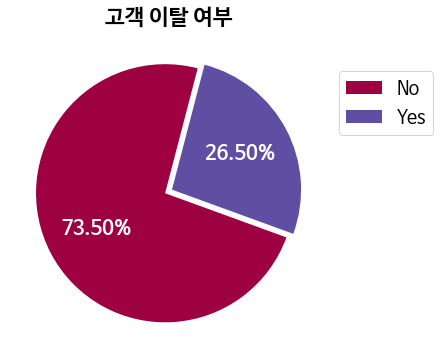

In [15]:
# 타겟 변수
target = "churn"
target_perc = train[target].value_counts(normalize=True)
label = ["No","Yes"]

explode = [0.03] * len(label)
cmap = plt.cm.Spectral
colors = cmap(np.linspace(0, 1.3, 2))

fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
ax.pie(target_perc, startangle=-20, counterclock=False,  colors=colors, explode=explode,
        autopct="%.2f%%", textprops={'fontsize': 20, 'weight': 'bold', 'color': 'white'})
ax.set_title("고객 이탈 여부", fontsize=22, weight="bold",loc="center")
plt.legend(label, fontsize=18, bbox_to_anchor=(1, 0.9))
plt.show();

* 타겟 변수인 고객 이탈여부를 살펴보면, 이탈한 사람이 약 26.5%, 이탈하지 않은 사람이 약 73.5%로 imbalanced된 데이터이다.
* 추후 분석시 class_weight 조정 또는 업/다운 샘플링을 통해 어느정도 데이터 균형을 맞춰주는 작업이 필요할 것 같다.

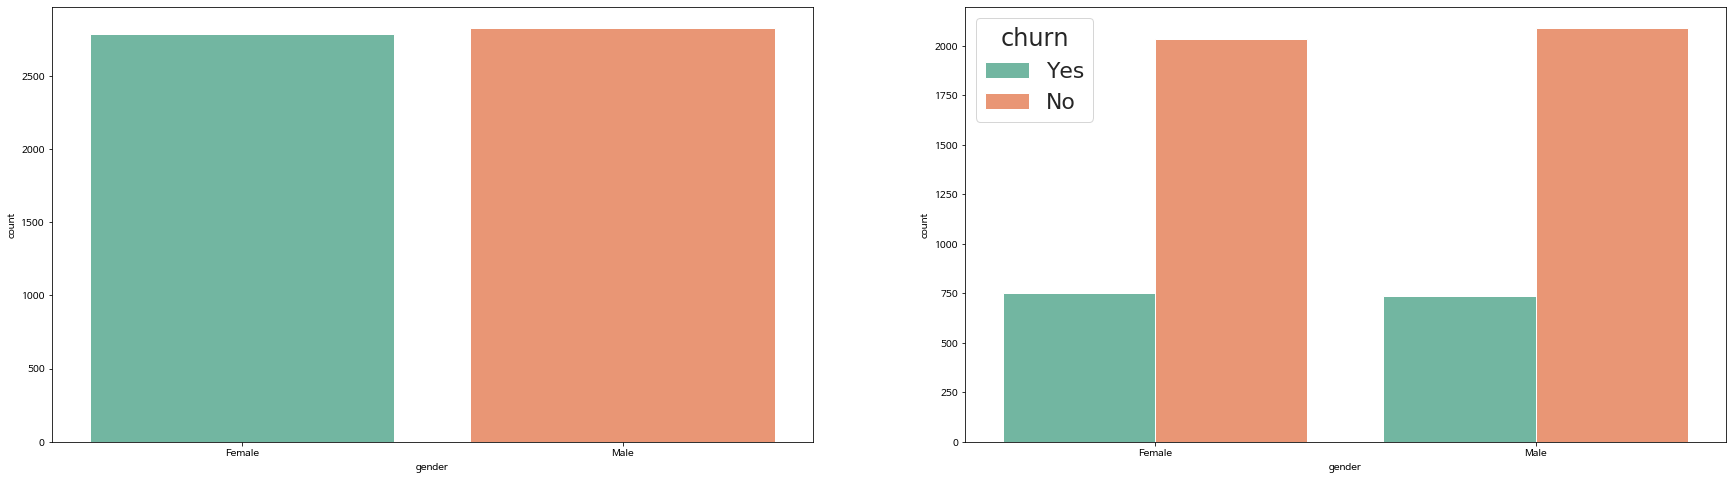

In [16]:
# 성별
f, ax = plt.subplots(1,2, figsize=(30,8))
sns.set(font_scale=2)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.countplot(train["gender"], ax=ax[0])
sns.countplot(train["gender"], hue=train[target], ax=ax[1]);

* 좌측 그림을 살펴보면 수집된 데이터에 성별의 차이는 없어 보인다.
* 우측 그림을 살펴보면 고객 이탈여부에 성별은 그다지 영향을 끼치지 않는 것 같다.

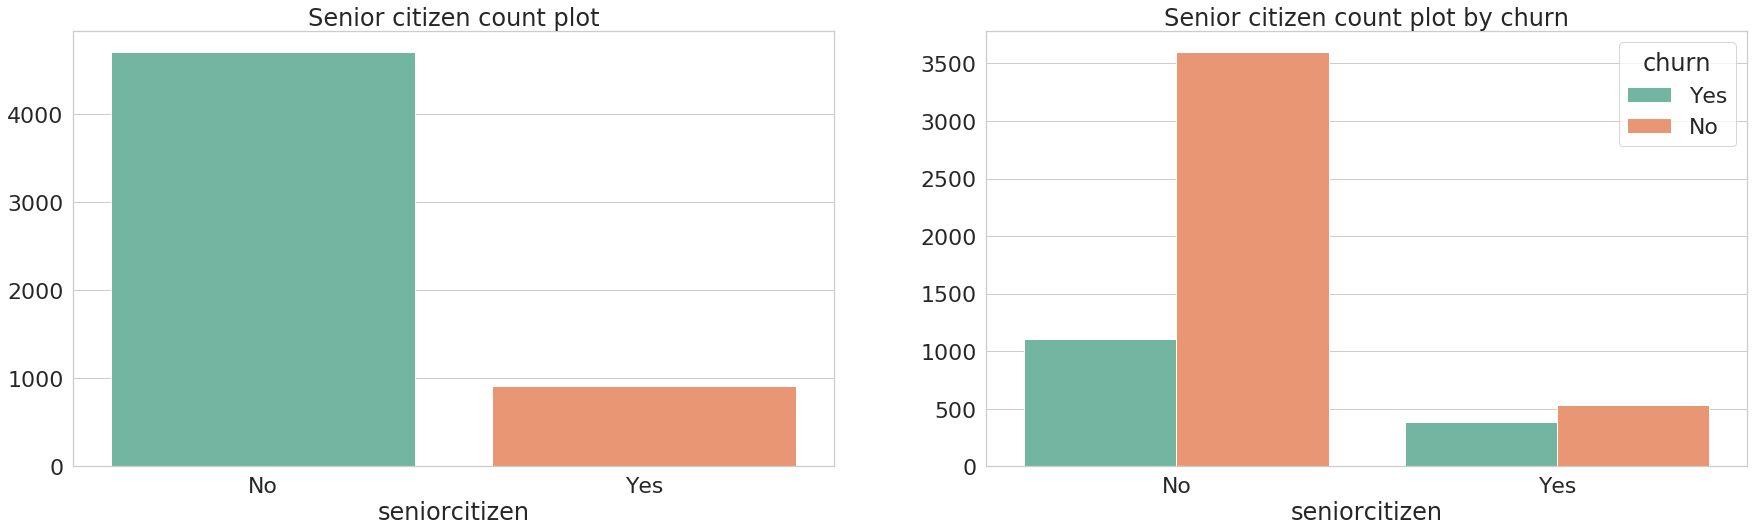

In [17]:
# seniorcitizen(고령자)
f, ax = plt.subplots(1,2, figsize=(30,8))
sns.countplot(train["seniorcitizen"], ax=ax[0])
ax[0].set(ylabel="", xticklabels=["No","Yes"], title="Senior citizen count plot")
sns.countplot(train["seniorcitizen"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="", xticklabels=["No","Yes"], title="Senior citizen count plot by churn");

* 데이터상으로 고령자의 데이터는 부족하다.
* 하지만 고령자의 경우 이탈율이 상대적으로 높은 상황이다.
* 데이터 개수가 적어 모델 변수 중요도에서 낮게 나올수도 있으나, 고령화 사회를 접어들고 있는 지금, 이러한 현황은 추후 중요하게 다뤄야할 부분으로 보인다

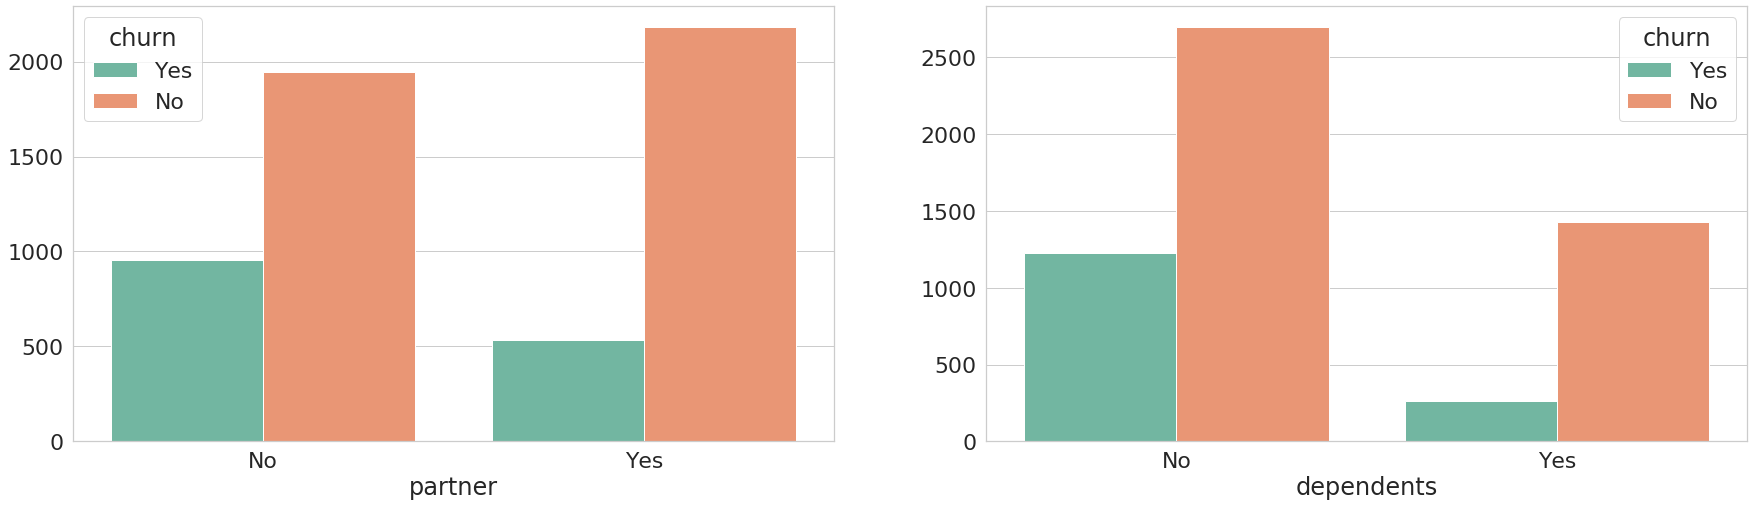

In [18]:
# 배우자(partner), 부양가족(dependents)
f, ax = plt.subplots(1,2, figsize=(30,8))
sns.countplot(train["partner"], hue=train[target], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["dependents"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* 배우자(parter)나 부양가족(dependents)이 있는 경우 이탈율이 상대적으로 낮다.

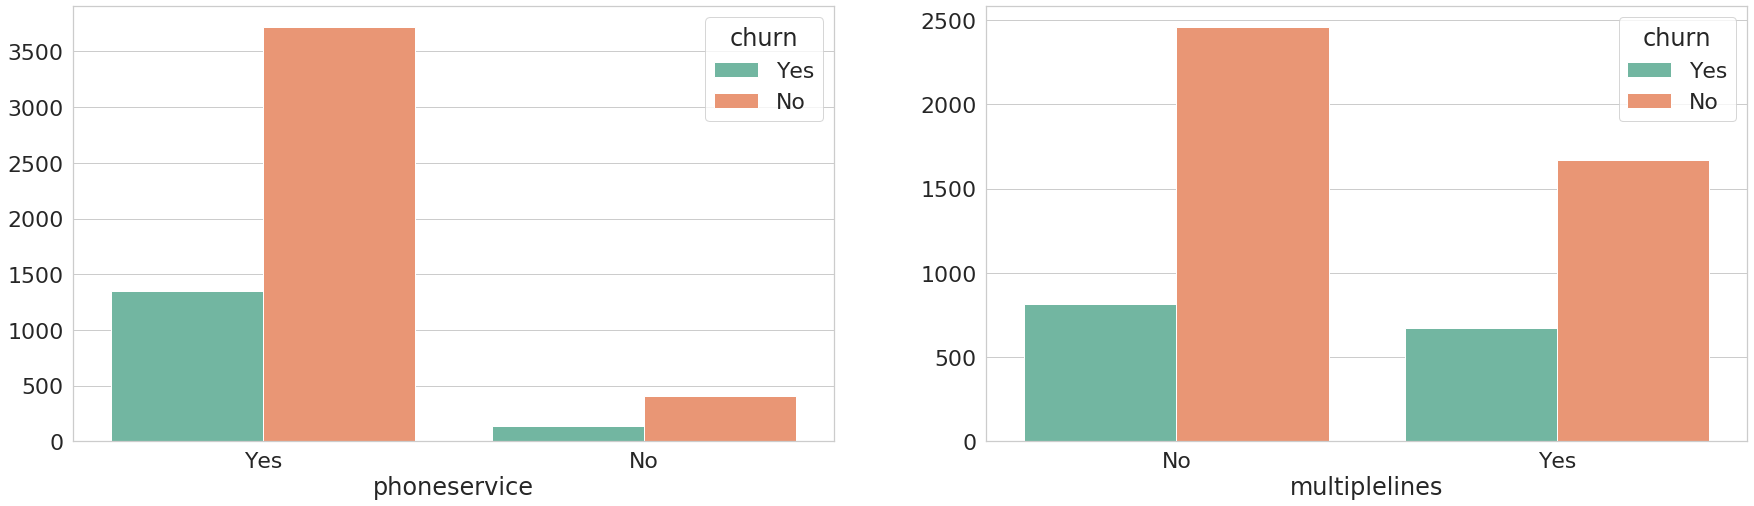

In [19]:
# phoneservice, multilines(여러 회신 서비스)
f, ax = plt.subplots(1,2, figsize=(30,8))
sns.countplot(train["phoneservice"], hue=train[target], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["multiplelines"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* 대부분 고객들은 폰 서비스를 활용하고 있다
* 비율적으로 봤을 때 여러회선을 사용하고 있는 경우, 조금 이탈율이 낮은 것 같다 => 결합할인을 받고 있을 가능성이 있다

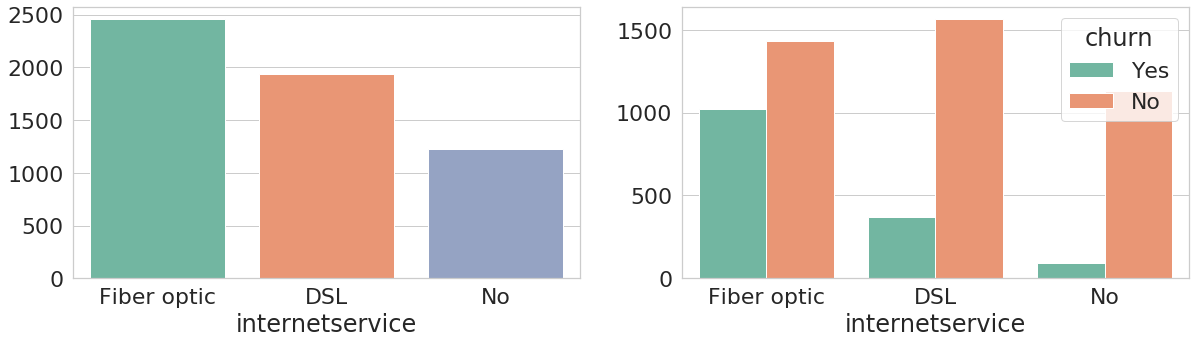

In [20]:
# 인터넷서비스
f,ax = plt.subplots(1,2, figsize=(20,5))
sns.countplot(train["internetservice"], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["internetservice"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* 인터넷 서비스 현황을 살펴보면, Fiber optic, DSL 순으로 많이 사용하고 있다
* 하지만 Fiber optic의 경우 이탈비율이 높다 => 고객들이 해당 서비스에 만족하지 못하고 있다
* DSL은 상대적으로 고객들이 만족할만한 인터넷서비스를 제공하고 있는 것으로 보인다

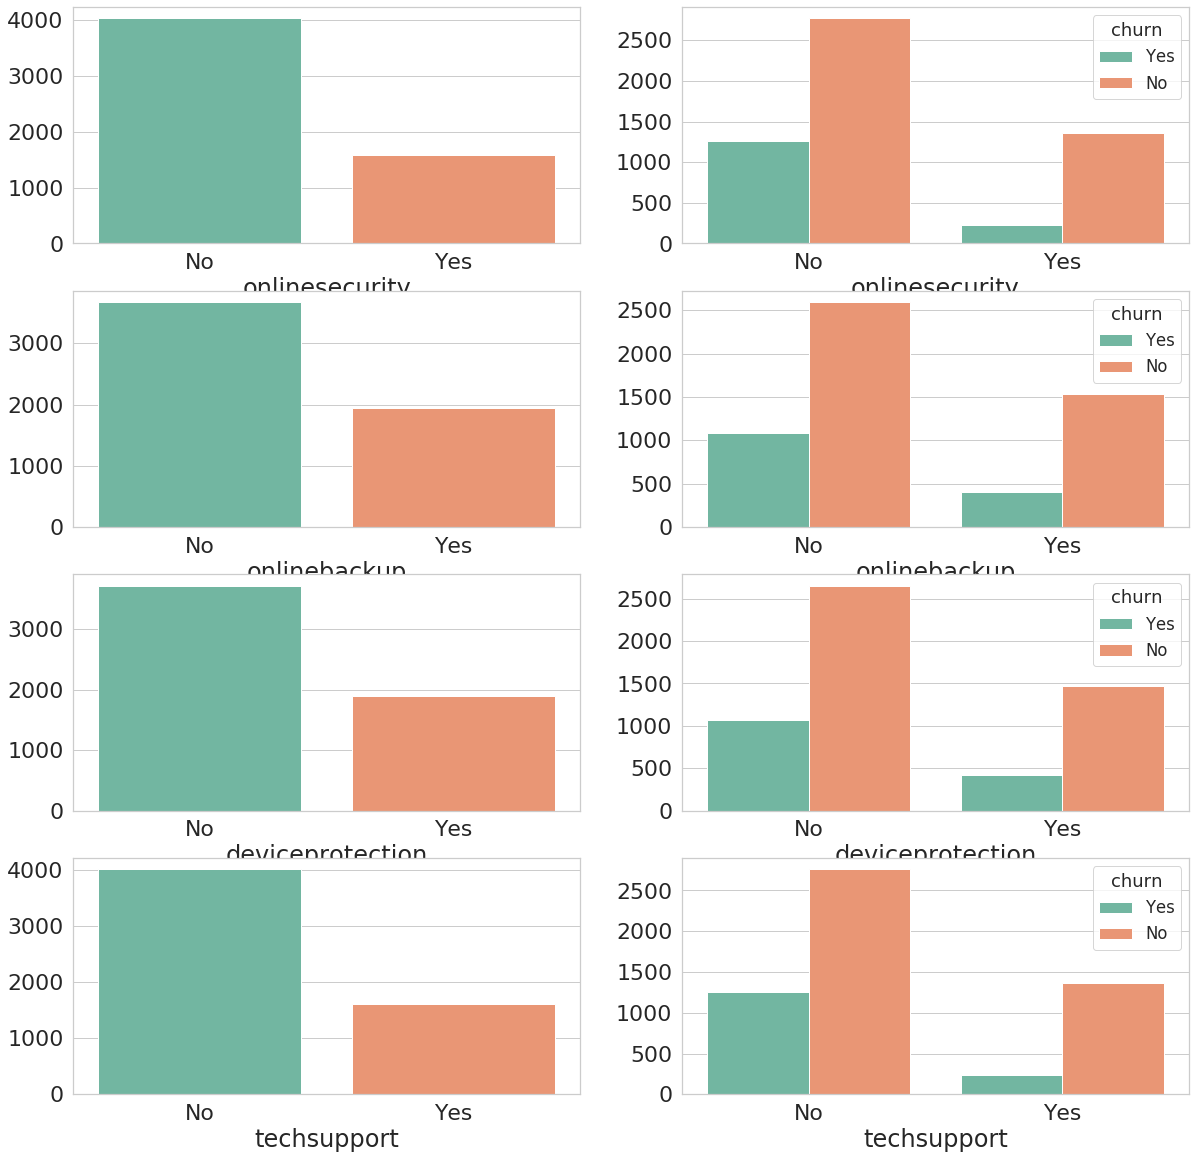

In [21]:
# 온라인 기술관련 서비스(onlinesecurity, onlinebackup, deviceprotection, techsupport)
f,ax = plt.subplots(4,2, figsize=(20,20))
sns.set(font_scale=1.5)
sns.set_palette("Set2")
sns.set_style("whitegrid")

sns.countplot(train["onlinesecurity"], ax=ax[0,0])
ax[0,0].set(ylabel="")
sns.countplot(train["onlinesecurity"], hue=train[target], ax=ax[0,1])
ax[0,1].set(ylabel="")

sns.countplot(train["onlinebackup"], ax=ax[1,0])
ax[1,0].set(ylabel="")
sns.countplot(train["onlinebackup"], hue=train[target], ax=ax[1,1])
ax[1,1].set(ylabel="")

sns.countplot(train["deviceprotection"], ax=ax[2,0])
ax[2,0].set(ylabel="")
sns.countplot(train["deviceprotection"], hue=train[target], ax=ax[2,1])
ax[2,1].set(ylabel="")

sns.countplot(train["techsupport"], ax=ax[3,0])
ax[3,0].set(ylabel="")
sns.countplot(train["techsupport"], hue=train[target], ax=ax[3,1])
ax[3,1].set(ylabel="");

* 통신사에서 제공하는 온라인 기술관련 서비스의 각각의 사용률 및 그에 따른 이탈여부의 분포는 거의 비슷하다
* 대체로 해당 서비스를 이용하고 있지 않았고, 이용하는 사람은 이탈할 확률이 좀 더 낮다 -> 온라인 서비스에 만족하고 있다 

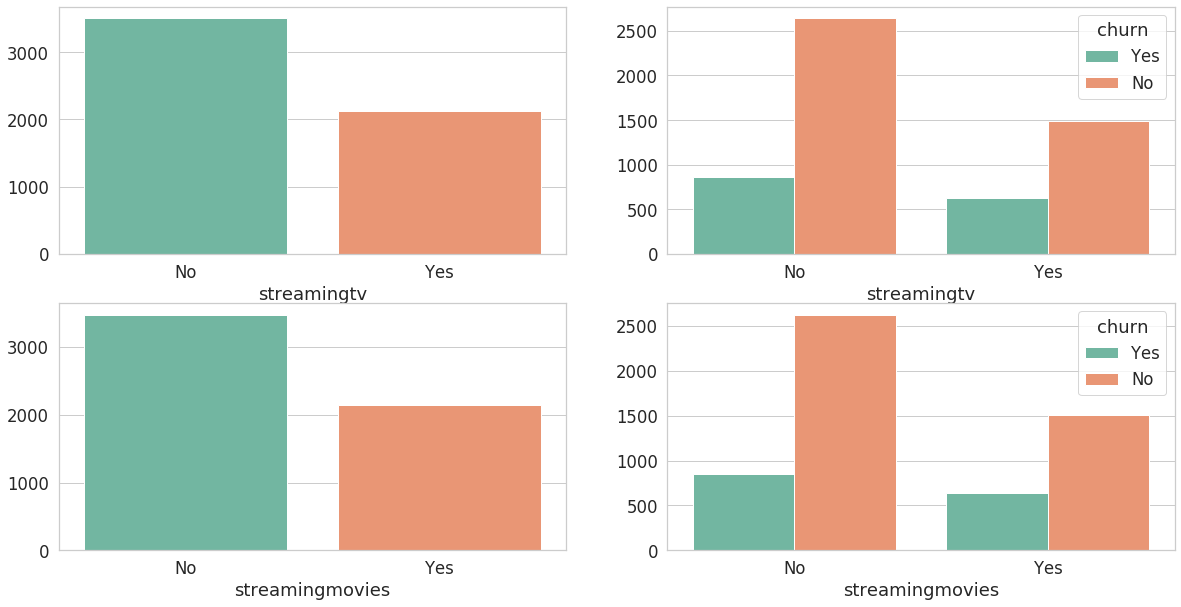

In [22]:
# 스트리밍 서비스(streamingTv, streamingMovie)
f,ax = plt.subplots(2,2, figsize=(20,10))

sns.countplot(train["streamingtv"], ax=ax[0,0])
ax[0,0].set(ylabel="")
sns.countplot(train["streamingtv"], hue=train[target], ax=ax[0,1])
ax[0,1].set(ylabel="")

sns.countplot(train["streamingmovies"], ax=ax[1,0], order=["No","Yes"])
ax[1,0].set(ylabel="")
sns.countplot(train["streamingmovies"], hue=train[target], order=["No","Yes"], ax=ax[1,1])
ax[1,1].set(ylabel="");


* 스트리밍 서비스를 사용하지 않는 고객의 수가 더 많다
* 스트리밍 서비스를 사용하는 고객의 이탈율이 조금 더 높아 보인다 => 스트리밍 서비스 보완 필요

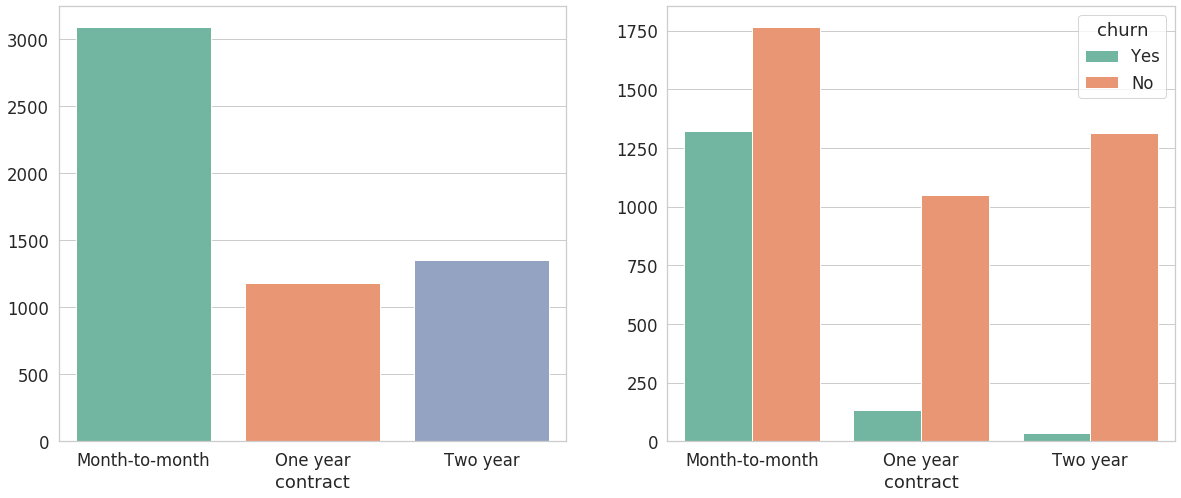

In [23]:
# contract(계약형태)
f,ax = plt.subplots(1,2, figsize=(20,8))
sns.countplot(train["contract"], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["contract"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* 매달 계약하는 고객의 수가 상대적으로 많다
* 장기계약하는 고객일수록 기존 통신사에서 이탈할 확률이 적고, 단기계약하는 고객이수록 이탈할 확률이 높다
* 단기계약 고객을 장기계약할 수 있도록 할 수 있는 유인책을 생각해보아야 한다

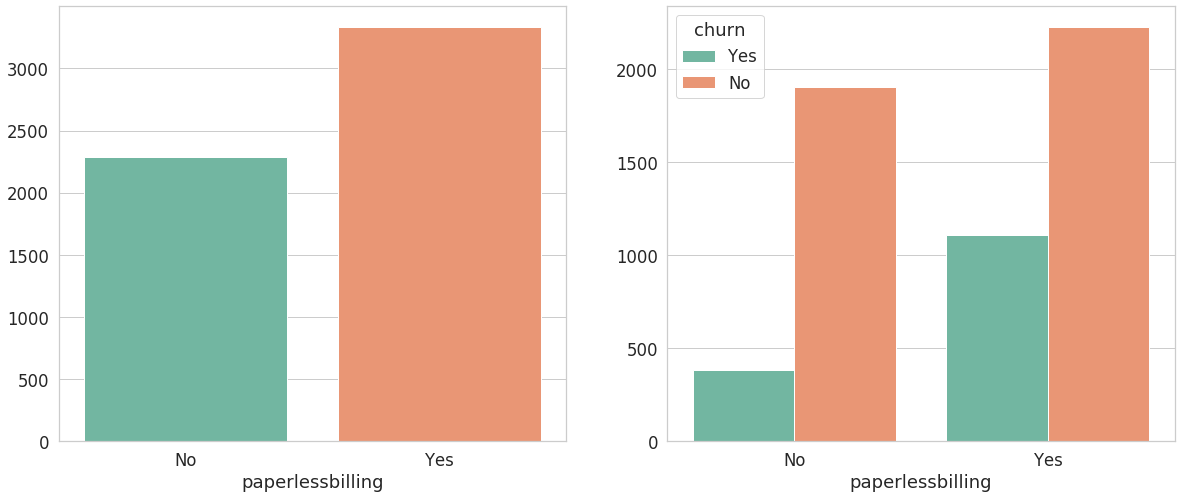

In [24]:
# 종이 영수증 사용여부
f,ax = plt.subplots(1,2, figsize=(20,8))
sns.countplot(train["paperlessbilling"], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["paperlessbilling"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* paperlessbilling 서비스를 사용한다는 것은 종이영수증을 받지않고, 전자영수증 또는 어플로 처리하겠다는 뜻이다
* 종이영수증을 사용하는 고객들에 비해 사용하지 않는 고객들이 많으나 그만큼 이탈자도 많다 => 해당 서비스의 품질이 좋지 않은 것은 아닌지 검토 필요

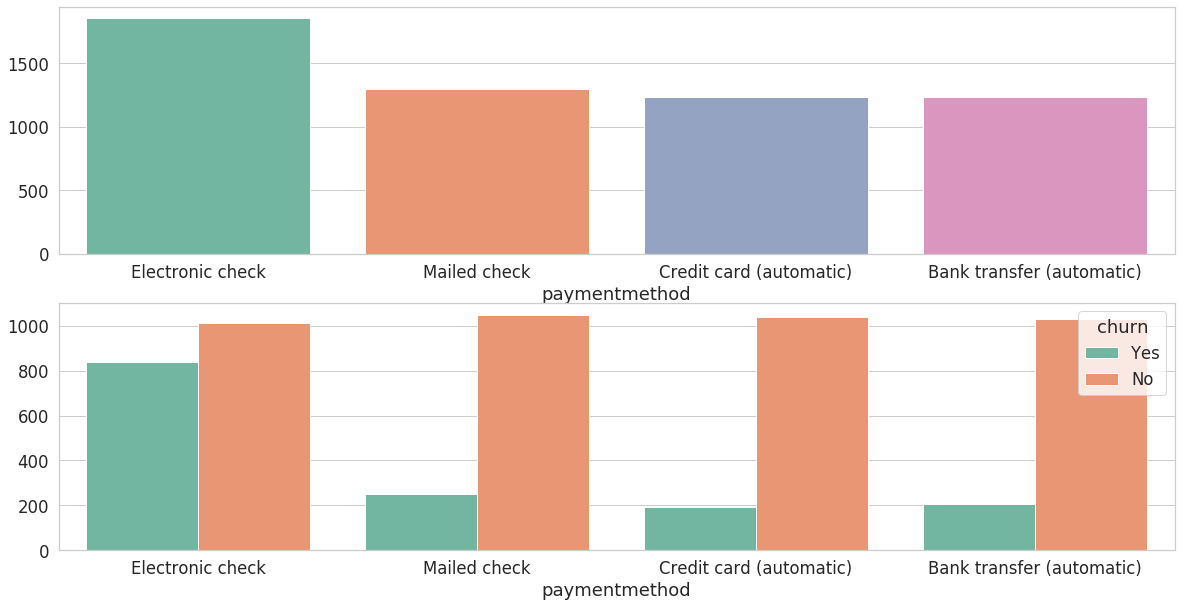

In [25]:
# 지불방식
f,ax = plt.subplots(2,1, figsize=(20,10))
sns.countplot(train["paymentmethod"], ax=ax[0])
ax[0].set(ylabel="")
sns.countplot(train["paymentmethod"], hue=train[target], ax=ax[1])
ax[1].set(ylabel="");

* Electronic Check방식을 가장 많이 사용하고 있으나, 이탈고객도 가장 많다 => 검토 필요

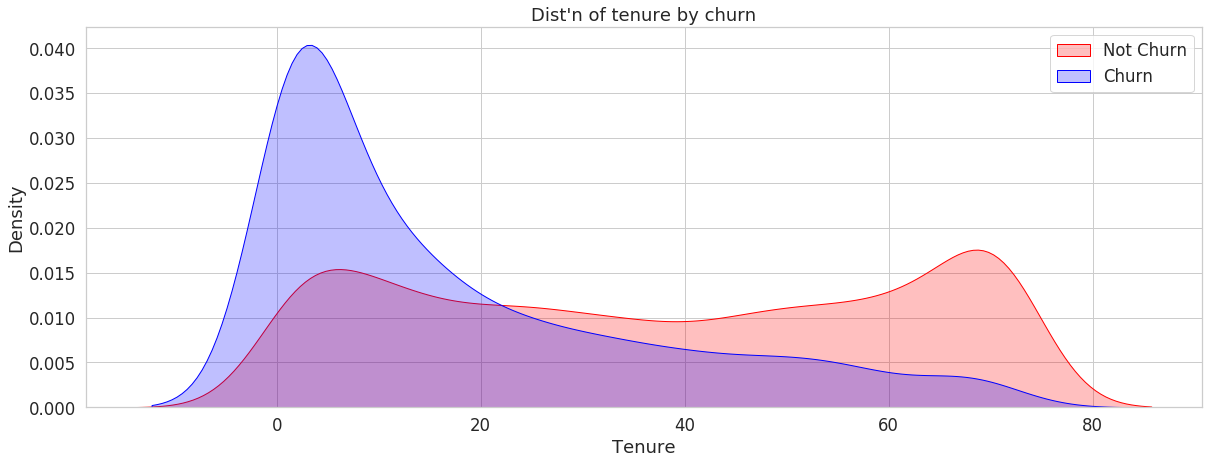

In [26]:
# 계약 유지기간
f,ax = plt.subplots(1,1,figsize=(20,7))
sns.kdeplot(train.tenure[(train["churn"] == 'No') ],
                ax=ax, color="Red", shade = True)
sns.kdeplot(train.tenure[(train["churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure')
ax.set_title("Dist'n of tenure by churn");

* 계약 유지 기간이 길어질수록 이탈하는 고객은 확연하게 줄어든다
* 위에서 살펴봤던 계약형태와도 밀접한 관련이 있어보인다

Text(0.5, 1.0, "Dist'n of total charges by churn")

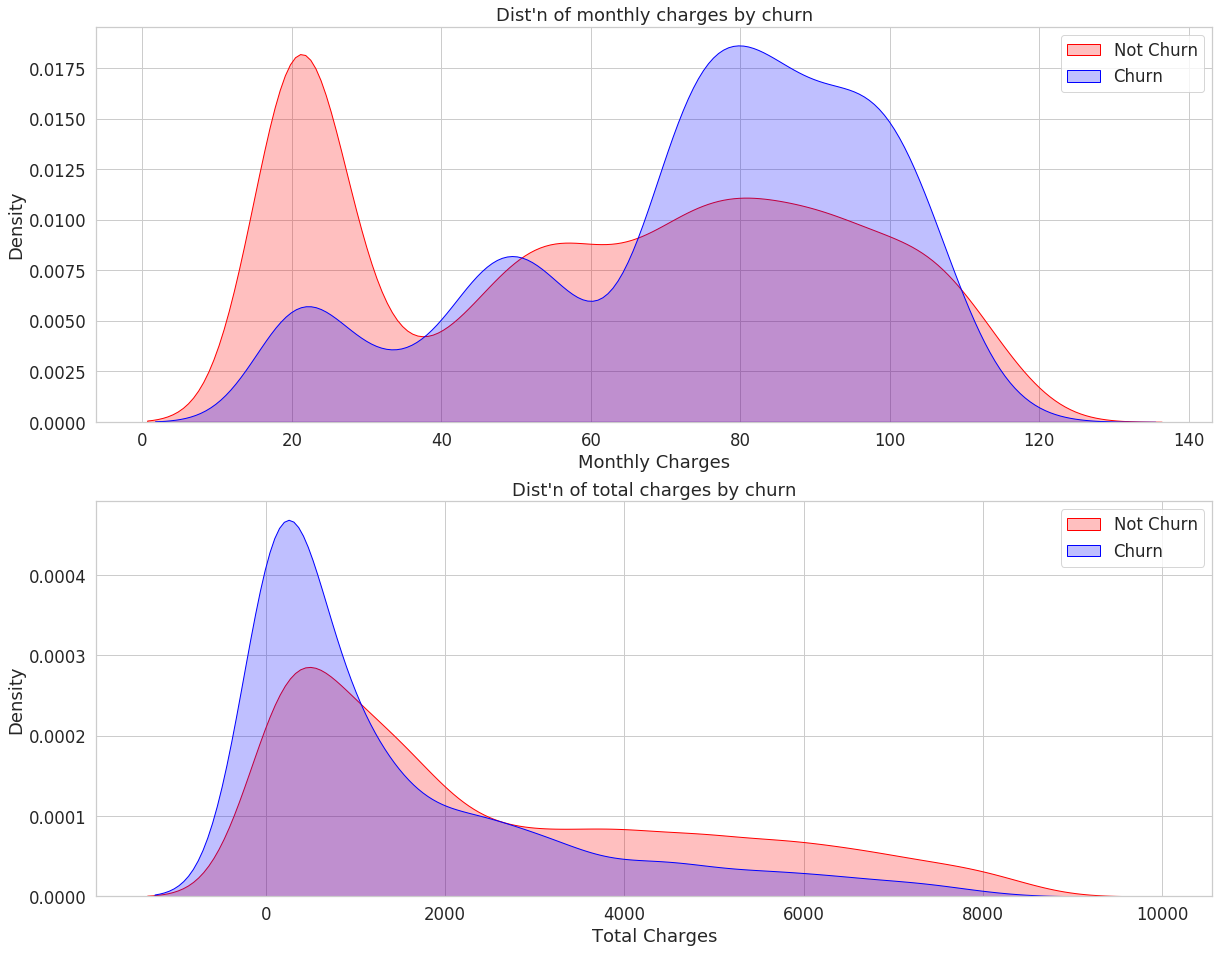

In [27]:
# 월 청구액 / 전체 지불액
f,ax = plt.subplots(2,1,figsize=(20,16))
sns.kdeplot(train.monthlycharges[(train["churn"] == 'No') ],
                ax=ax[0], color="Red", shade = True)
sns.kdeplot(train.monthlycharges[(train["churn"] == 'Yes') ],
                ax =ax[0], color="Blue", shade= True)
ax[0].legend(["Not Churn","Churn"],loc='upper right')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Monthly Charges')
ax[0].set_title("Dist'n of monthly charges by churn")

sns.kdeplot(train.totalcharges[(train["churn"] == 'No') ],
                ax=ax[1], color="Red", shade = True)
sns.kdeplot(train.totalcharges[(train["churn"] == 'Yes') ],
                ax =ax[1], color="Blue", shade= True)
ax[1].legend(["Not Churn","Churn"],loc='upper right')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Total Charges')
ax[1].set_title("Dist'n of total charges by churn")

* 월 청구액이 많을수록 이탈확률이 높다
* 전체 청구액이 적을수록 이탈확률이 높다 (tenure와 연관되어 보임) => tenure(계약 유지기간)의 값이 작다는 것이 곧 전체 납부액이 적다는 말과 일맥상통

### Feature Engineering

In [28]:
train2 = train.copy()
train2["predict"] = train2["tenure"] * train2["monthlycharges"]
train2[["tenure","monthlycharges","totalcharges","predict"]]

,tenure,monthlycharges,totalcharges,predict
1898,5,78.95,378.40,394.75
3709,1,50.75,50.75,50.75
259,29,45.00,1228.65,1305.00
5232,2,20.30,40.25,40.60
4627,60,116.60,7049.50,6996.00
...,...,...,...,...
6458,6,49.15,295.65,294.90
3614,69,60.25,4055.50,4157.25
5716,2,55.30,108.65,110.60
6655,63,24.20,1618.20,1524.60


* 계약 유지기간(tenure)동안 원래 설정했던 서비스를 변동없이 계속해서 사용했다면 월 납부액은 동일했을 것이다 
* 그렇다면 **`계약 유지기간(tenure) * 월납부액(monthlycharges) = 전채납부액(totalcharges)`**의 식이 성립해야 한다고 생각했다
* 하지만 대부분 위에서 예측한 예상과 동일하지 않았다 -> 달에 따라 고객이 서비스 가입 상품을 바꿨을 수도 있고 프로모션 혜택을 받았을 수도 있을 것 같다
* 따라서 계약기간동안 동일한 월납부액을 냈다는 가정하에 예상금액과 실제 전체 납부액 간의 차이를 나타내 주는 칼럼을 추가해주었다

In [29]:
def engineer(df):
    # 예상 전체 납부액과 실제 전체 납부액의 차이 칼럼 추가
    df["prediceted_diff"] = (df["tenure"] * df["monthlycharges"]) - df["totalcharges"]

    # {yes/no, male/female}범주의 칼럼 1,0으로 인코딩
    for col in df.columns:
        if df[col].nunique() == 2:
            df[col] = df[col].apply(lambda x: 1 if (x=="Yes") or (x=="Male") else 0 if (x=="No") or (x=="Female") else x)

    # 온라인 기술관련 서비스 가입 개수
    df["#security_service"] = df["onlinesecurity"] + df["onlinebackup"] + df["deviceprotection"] + df["techsupport"]

    # 스트리밍 서비스 가입 개수
    df["#streaming_service"] = df["streamingtv"] + df["streamingmovies"]

    return df

train = engineer(train)
test = engineer(test)

In [30]:
train.to_csv('train.csv')

In [31]:
test.to_csv('test.csv')